## Import Libraries and install packages and framworks

In [176]:
# !pip install tensorflow
# !pip install keras
# !pip install tensorflow-addons
# !pip3 install tfa-nightly
import numpy as np
import pandas as pd
import seaborn as sns
import matplotlib.pyplot as plt

from sklearn.preprocessing import StandardScaler    
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, classification_report

import tensorflow as tf
import keras
import tensorflow_addons as tfa

from sklearn.preprocessing import LabelEncoder
from tensorflow.keras import Sequential
from tensorflow.keras.layers import Dense
from keras.layers import BatchNormalization
from tensorflow.keras.optimizers import SGD
from tensorflow.keras.layers import Dense, Dropout, Activation,Flatten,Reshape

## Data preparation.

In [187]:
#load data
X_test=pd.read_csv('/home/sid2020-7/Bureau/DATA1/FINAL DATA/X_test_final.csv')
y_test=pd.read_csv('/home/sid2020-7/Bureau/DATA1/FINAL DATA/y_test_final.csv')
trainX=pd.read_csv('/home/sid2020-7/Bureau/DATA1/FINAL DATA/X_train_final.csv')
trainy=pd.read_csv('/home/sid2020-7/Bureau/DATA1/FINAL DATA/y_train_final.csv')

In [194]:
# the dataset imbalance:
posts,negts  = np.bincount(trainy['TOP_FRAUDE'])
postr ,negtr = np.bincount(y_test['TOP_FRAUDE'])

pos=posts+postr 
neg=negts+negtr 
total = neg + pos
print('pour la classe 0: {} ({:.2f}% of total)\n'.format(pos, 100 * pos / total))
print('pour la classe 1: {} ({:.2f}% of total)\n'.format(neg, 100 * neg / total))

pour la classe 0: 547182 (99.70% of total)

pour la classe 1: 1630 (0.30% of total)



In [189]:
# Split data test to test and validation datasets.
testX, tvalX, testy, tvaly = train_test_split(X_test, y_test, test_size=0.5, random_state=2,stratify=y_test)

## Loss Functions & Metrics.

Metrics: the binary classification metrics that are used for the imbalanced data are F2Beta and curve (ROC-AUC).

Loss functions: the binary classification loss functions available in Keras and most adaptable to tow metrics are:
 'binary_crossentropy'.
 tfa.losses.SigmoidFocalCrossEntropy()

 In classification problems involving imbalanced data and outlier detection problems,
 the focal loss function seems to be the most efficient for an ANN.
 This loss introduces an adjustment to the cross-entropy criterion. 
 For this we chose the loss.SigmoidFocalCrossEntropy().




In [274]:
 METRICS=[tfa.metrics.FBetaScore(name='FBeta2',num_classes=2,average="micro",threshold=0.5),
         tf.keras.metrics.AUC(name='prc', curve='PR'),]

## Build the model

In [302]:
n_features = trainX.shape[1]
# The model tak
def model(output_bias=None):
    if output_bias is not None:
        output_bias = tf.keras.initializers.Constant(output_bias)
    model = Sequential()
    model.add(Dense(32, activation='sigmoid', kernel_initializer='he_normal', input_shape=(n_features,)))
#     model.add(Dense(62,activation='relu', kernel_initializer='he_normal')),
    model.add(Dense(62,activation='sigmoid', kernel_initializer='he_normal')),
    model.add(Dense(62,activation='sigmoid', kernel_initializer='he_normal')),
    model.add(Dense(124,activation='sigmoid', kernel_initializer='he_normal')),
    model.add(Dense(124,activation='sigmoid', kernel_initializer='he_normal')),
    model.add(Dense(62,activation='sigmoid', kernel_initializer='he_normal')),
    model.add(Dense(62,activation='sigmoid', kernel_initializer='he_normal')),
#     model.add(Dropout(0.5)),
#     model.add(BatchNormalization())

    model.add(Dense(1, activation='sigmoid')),
    model.compile(optimizer='adam', loss=tfa.losses.SigmoidFocalCrossEntropy(), metrics=[METRICS])

    return model


#### Bais
We set the initial bias basing on this forlmula:

$$ p_0 = pos/(pos + neg) = 1/(1+e^{-b_0}) $$
$$ b_0 = -log_e(1/p_0 - 1) $$
$$ b_0 = log_e(pos/neg)$$

In [301]:
initial_bias = np.log([pos/neg])
initial_bias

array([5.81620146])

#### Calculate class weights

Identify the minor and major class, and give weights to class_weight which helps us optimize the scoring for the minor class.These will help the model to "pay more attention" to examples from an under-represented class.

In [300]:
total = neg + pos
poids_0 = (1 / neg) * (total / 2.0)
poids_1 = (1 / pos) * (total / 2.0)
class_weight = {0: poids_1, 1: poids_0}
class_weight
print('poid pour la classe 0: {:.2f}'.format(weight_for_0))
print('poids pour la classe 1: {:.2f}'.format(weight_for_1))

poid pour la classe 0: 168.35
poids pour la classe 1: 0.50


In [303]:
# summary model.
model= model(output_bias=initial_bias)
model.summary()

Model: "sequential_54"
_________________________________________________________________
 Layer (type)                Output Shape              Param #   
 dense_271 (Dense)           (None, 32)                1984      
                                                                 
 dense_272 (Dense)           (None, 62)                2046      
                                                                 
 dense_273 (Dense)           (None, 62)                3906      
                                                                 
 dense_274 (Dense)           (None, 124)               7812      
                                                                 
 dense_275 (Dense)           (None, 124)               15500     
                                                                 
 dense_276 (Dense)           (None, 62)                7750      
                                                                 
 dense_277 (Dense)           (None, 62)              

## Training the ANN model.
Our model is fit using a larger than default batch size of 3000, this is important to ensure that each batch has a decent chance of containing a few class 0 samples. If the batch size was too small, they would likely have no fraudulent transactions to learn from.

In [304]:
EPOCHS = 100
batch_size = 3000
fit_model=model.fit(trainX, trainy,
        batch_size = batch_size,
        epochs=EPOCHS, 
        verbose=1,
        validation_data = (tvalX, tvaly),  
        class_weight={0 : 0.5, 1 : 169})


Epoch 1/100
98/98 [==============================] - 3s 21ms/step - loss: 0.0849 - FBeta2: 0.0122 - prc: 0.0046 - val_loss: 0.0731 - val_FBeta2: 0.0000e+00 - val_prc: 0.0038
Epoch 2/100
98/98 [==============================] - 2s 18ms/step - loss: 0.0749 - FBeta2: 0.0285 - prc: 0.0124 - val_loss: 0.0750 - val_FBeta2: 0.0120 - val_prc: 0.0063
Epoch 3/100
98/98 [==============================] - 4s 37ms/step - loss: 0.0634 - FBeta2: 0.0340 - prc: 0.0244 - val_loss: 0.0702 - val_FBeta2: 0.0130 - val_prc: 0.0075
Epoch 4/100
98/98 [==============================] - 3s 30ms/step - loss: 0.0629 - FBeta2: 0.0368 - prc: 0.0266 - val_loss: 0.0944 - val_FBeta2: 0.0110 - val_prc: 0.0077
Epoch 5/100
98/98 [==============================] - 2s 23ms/step - loss: 0.0612 - FBeta2: 0.0392 - prc: 0.0482 - val_loss: 0.0608 - val_FBeta2: 0.0141 - val_prc: 0.0083
Epoch 6/100
98/98 [==============================] - 4s 36ms/step - loss: 0.0610 - FBeta2: 0.0398 - prc: 0.0419 - val_loss: 0.0792 - val_FBeta2: 0

Epoch 49/100
98/98 [==============================] - 3s 35ms/step - loss: 0.0494 - FBeta2: 0.0561 - prc: 0.1331 - val_loss: 0.0851 - val_FBeta2: 0.0131 - val_prc: 0.0079
Epoch 50/100
98/98 [==============================] - 3s 34ms/step - loss: 0.0494 - FBeta2: 0.0540 - prc: 0.1266 - val_loss: 0.0739 - val_FBeta2: 0.0135 - val_prc: 0.0077
Epoch 51/100
98/98 [==============================] - 2s 20ms/step - loss: 0.0499 - FBeta2: 0.0524 - prc: 0.1133 - val_loss: 0.0740 - val_FBeta2: 0.0138 - val_prc: 0.0079
Epoch 52/100
98/98 [==============================] - 3s 26ms/step - loss: 0.0495 - FBeta2: 0.0532 - prc: 0.1331 - val_loss: 0.0877 - val_FBeta2: 0.0126 - val_prc: 0.0078
Epoch 53/100
98/98 [==============================] - 3s 29ms/step - loss: 0.0494 - FBeta2: 0.0533 - prc: 0.1292 - val_loss: 0.0608 - val_FBeta2: 0.0137 - val_prc: 0.0076
Epoch 54/100
98/98 [==============================] - 3s 34ms/step - loss: 0.0489 - FBeta2: 0.0545 - prc: 0.1318 - val_loss: 0.0774 - val_FBeta2:

Epoch 97/100
98/98 [==============================] - 2s 20ms/step - loss: 0.0403 - FBeta2: 0.0474 - prc: 0.1278 - val_loss: 0.0391 - val_FBeta2: 0.0141 - val_prc: 0.0069
Epoch 98/100
98/98 [==============================] - 2s 22ms/step - loss: 0.0397 - FBeta2: 0.0499 - prc: 0.1308 - val_loss: 0.0601 - val_FBeta2: 0.0127 - val_prc: 0.0072
Epoch 99/100
98/98 [==============================] - 2s 21ms/step - loss: 0.0376 - FBeta2: 0.0489 - prc: 0.1325 - val_loss: 0.0670 - val_FBeta2: 0.0125 - val_prc: 0.0072
Epoch 100/100
98/98 [==============================] - 3s 28ms/step - loss: 0.0371 - FBeta2: 0.0492 - prc: 0.1398 - val_loss: 0.0612 - val_FBeta2: 0.0124 - val_prc: 0.0069


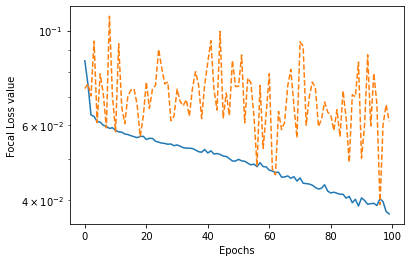

In [305]:
# loss function value for train and for validation setes by epoch.

def plot_loss(fited_model):
  plt.semilogy(fited_model.epoch, fited_model.history['loss'], label='Train ' )
  plt.semilogy(fited_model.epoch, fited_model.history['val_loss'], label='Val ' ,linestyle="--")
  plt.xlabel('Epochs')
  plt.ylabel('Focal Loss value')
plot_loss(fit_model)

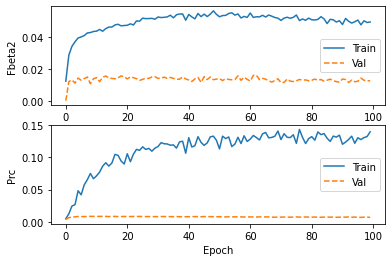

In [306]:
# metrics ('FBeta2' and 'prc') values for train and for validation setes by epoch.
def plot_metrics(history):
  metrics = ['FBeta2', 'prc']
  for n, metric in enumerate(metrics):
    name = metric.replace("_"," ").capitalize()
    plt.subplot(2,1,n+1)
    plt.plot(history.epoch, history.history[metric],label='Train')
    plt.plot(history.epoch, history.history['val_'+metric],linestyle="--", label='Val')
    plt.xlabel('Epoch')
    plt.ylabel(name)
    plt.legend();
plot_metrics(fit_model)

## Test Evaluate the model performance.

In [307]:
## Prediction on test data. 
y_pred = model.predict(testX)
y_pred_proba=y_pred[:,0]
y_label=testy['TOP_FRAUDE']

# Proportion of predected outliers by reel outliers. 
def plot_proportion_anomalies(y_label,y_pred_proba) :
    s = [(i,y) for i,y in zip(y_label,y_pred_proba)]
    #print(s)
    s = sorted(s, key=lambda item: item[1])
    anomalies_sorted = [i[0] for i in s]
    number_anomalies = sum(anomalies_sorted)
    liste_prop_anomalies = []

    for seuil in range(0,100,1) :
        borne_inf = int(len(anomalies_sorted)*(1-seuil/100))
        number_ano_sample = sum(anomalies_sorted[borne_inf:])
        liste_prop_anomalies.append(number_ano_sample/number_anomalies)
        print("Pour le seuil : :",seuil,"il y'a un pourcentage de :",number_ano_sample/number_anomalies)

    plt.plot( range(0,100,1),np.array(liste_prop_anomalies)*100)
    plt.plot(range(0,100,1),range(0,100,1))

Pour le seuil : : 0 il y'a un pourcentage de : 0.0
Pour le seuil : : 1 il y'a un pourcentage de : 0.04743083003952569
Pour le seuil : : 2 il y'a un pourcentage de : 0.09090909090909091
Pour le seuil : : 3 il y'a un pourcentage de : 0.1422924901185771
Pour le seuil : : 4 il y'a un pourcentage de : 0.18972332015810275
Pour le seuil : : 5 il y'a un pourcentage de : 0.23715415019762845
Pour le seuil : : 6 il y'a un pourcentage de : 0.2608695652173913
Pour le seuil : : 7 il y'a un pourcentage de : 0.31620553359683795
Pour le seuil : : 8 il y'a un pourcentage de : 0.3557312252964427
Pour le seuil : : 9 il y'a un pourcentage de : 0.3952569169960474
Pour le seuil : : 10 il y'a un pourcentage de : 0.4268774703557312
Pour le seuil : : 11 il y'a un pourcentage de : 0.4624505928853755
Pour le seuil : : 12 il y'a un pourcentage de : 0.48616600790513836
Pour le seuil : : 13 il y'a un pourcentage de : 0.5138339920948617
Pour le seuil : : 14 il y'a un pourcentage de : 0.5335968379446641
Pour le seuil 

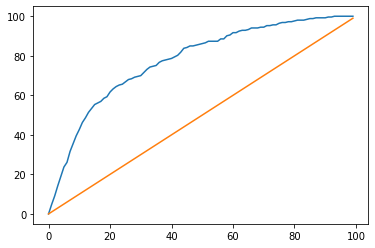

In [308]:
plot_proportion_anomalies(y_label,y_pred_proba)

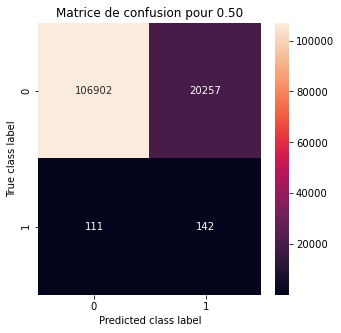

In [309]:
def plot_cm(labels, predictions, p=0.5):
  cm = confusion_matrix(labels, predictions > p)
  plt.figure(figsize=(5,5))
  sns.heatmap(cm, annot=True, fmt="d")
  plt.title('Matrice de confusion pour {:.2f}'.format(p))
  plt.ylabel('True class label')
  plt.xlabel('Predicted class label')
test_predictions=model.predict(testX, batch_size=3000)
plot_cm(testy, test_predictions)
# as we can see the model found 142 outliers of class 1 for a threshold 0.5 of probabilty.